# Objetivo del proyecto

En este notebook queremos enfrentarnos a un problema de regresión pero basándonos en el análisis de series temporales. El objetivo es analizar un dataset que contiene los puntos de un equipo durante las últimas décadas, y el objetivo es analizar cómo fluctua esa variable y predecir el valor usando redes neuronales.

Este proyecto se basa en el siguiente paper: http://www.eajournals.org/wp-content/uploads/A-Comparative-Time-Series-Analysis-of-Points-Scored-by-Arsenal-Football-Club.pdf

<br>
Por lo tanto, será un problema de regresión. En este problema tenemos un dataset en el que cada muestra corresponde a un año y contiene el número de puntos que un equipo logró en la liga doméstica.

Por lo tanto:
 - Será un sistema supervisado porque tenemos un dataset equipos con los puntos en cada año, y queremos predecir los puntos.
 - Será un sistema de regresión porque queremos predecir un valor continuo.

Datos: los datos que se utilizan han sido extraidos de la wikipedia.

##### Importamos las librerías

In [211]:
import warnings
warnings.filterwarnings(action="ignore")

import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np

from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sn

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

import tensorflow as tf
from tensorflow import keras

##### Funciones

La función AddModel se ha creado para ir añadiendo a un dataframe los modelos que se van a ir probando, así podremos ir completando una tabla con diferentes modelos y sus métricas para su posterior comparación.

In [212]:
model_comparative = pd.DataFrame(columns=['RMSE'])





def AddModel(metric, value, model_comparative):
    # Crear un DataFrame con la métrica y el valor directamente
    met = pd.DataFrame({'RMSE': [np.round(value, 3)]}, index=[metric])

    # Concatenar el nuevo modelo al DataFrame existente
    model_comparative = pd.concat([model_comparative, met])

    # Ordenar el DataFrame por la columna 'RMSE' en orden ascendente
    model_comparative = model_comparative.sort_values(by=['RMSE'], ascending=True)

    return model_comparative


## Exploratory Data Analysis

In [213]:
dt = pd.read_csv(r'C:\Users\Arnau Climent\OneDrive\Documentos\1_MASTER\M07\TS Analysis\data\arsenal_points.csv')
# dt = pd.read_csv('arsenal_points.csv')

In [214]:
dt.head()

,Season,Division,Points
0,1904–05,Div 1,33
1,1905–06,Div 1,37
2,1906–07,Div 1,44
3,1907–08,Div 1,36
4,1908–09,Div 1,38


In [215]:
dt.info()

<class 'pandas.core.frame.DataFrame'>
Index: 105 entries, 0 to 104
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Season    105 non-null    object
 1   Division  105 non-null    object
 2   Points    105 non-null    int64 
dtypes: int64(1), object(2)
memory usage: 3.3+ KB


##### Construimos el dataset como una serie para trabajar con ella

In [216]:
ts = pd.DataFrame(dt['Points'])
ts.index = dt['Season']

ts.head()

,Points
Season,
1904–05,33
1905–06,37
1906–07,44
1907–08,36
1908–09,38


Text(0, 0.5, 'Puntos')

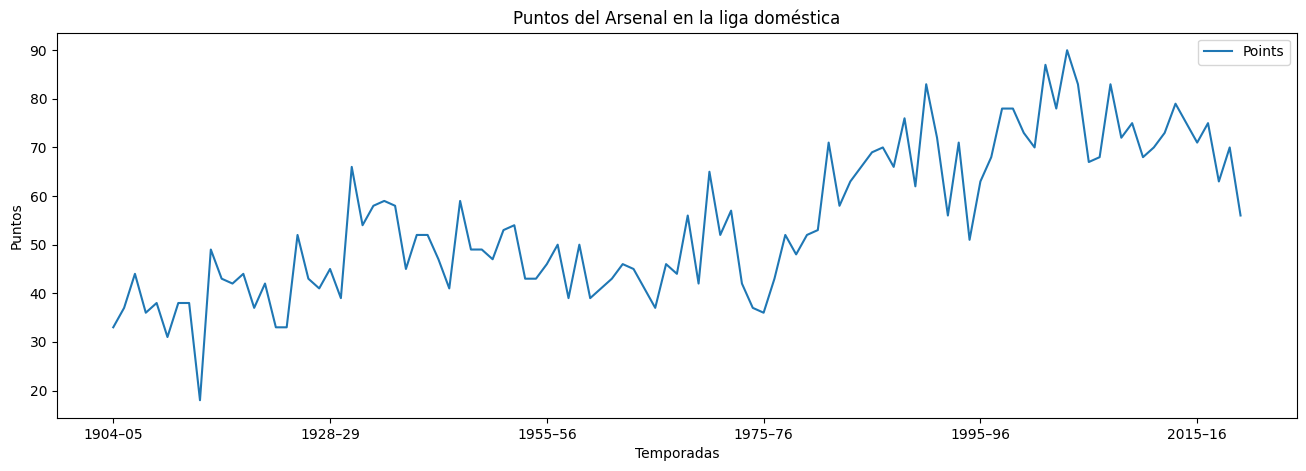

In [217]:
ax = ts.plot(figsize=(16,5), title='Puntos del Arsenal en la liga doméstica')
ax.set_xlabel("Temporadas")
ax.set_ylabel("Puntos")

### Componentes de una serie temporal

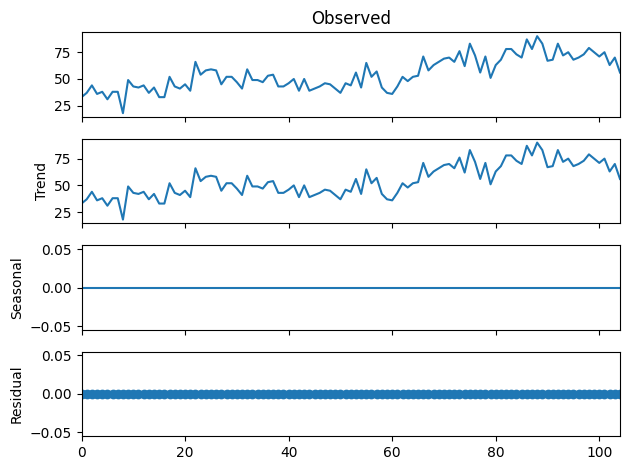

In [218]:
result = seasonal_decompose(ts.values, model='additive', period=1)
result.plot();

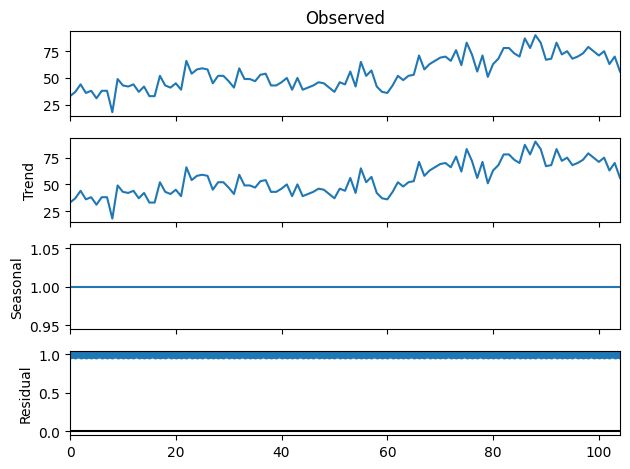

In [219]:
result = seasonal_decompose(ts.values, model='multiplicative', period=1)
result.plot();

### Autocorrelación

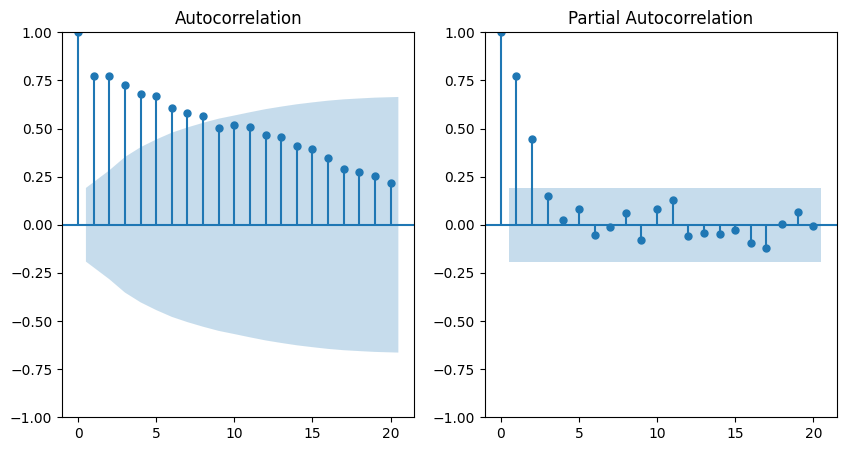

In [220]:
# Visualizamos las autocorrelaciones
fig, ax = plt.subplots(1,2,figsize=(10,5))
plot_acf(ts, lags=20, ax=ax[0])
plot_pacf(ts, lags=20, ax=ax[1])
plt.show()

### Estacionariedad

In [221]:
from statsmodels.tsa.stattools import adfuller

adf_test = adfuller(ts)
print("The p-value: ", adf_test[1])

The p-value:  0.2042415330146527


## Data Processing

### Provocando estacionariedad

Text(0, 0.5, 'Puntos')

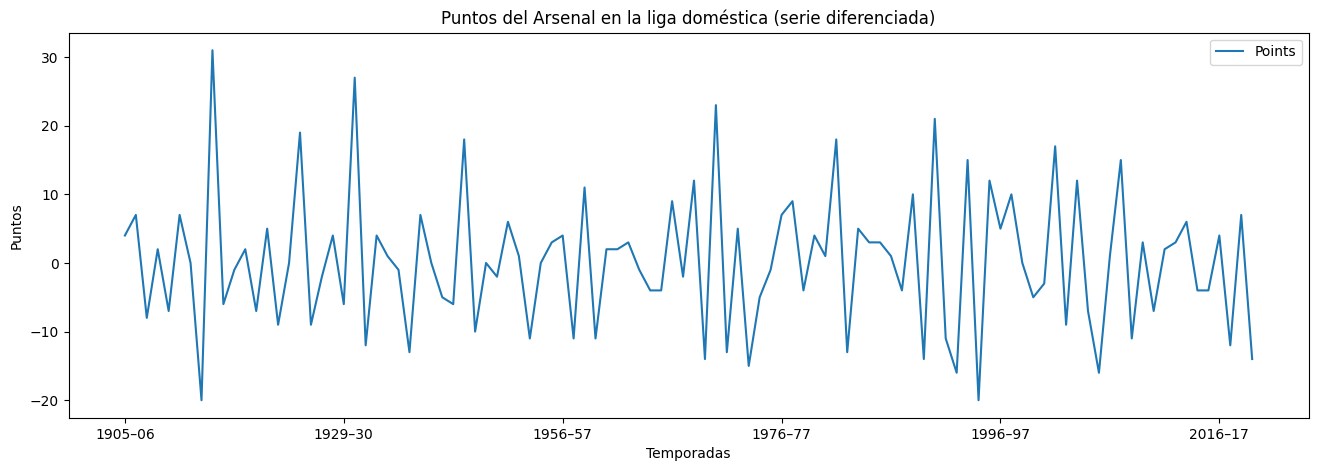

In [222]:
ts_bef =  ts.shift(periods=1)
ts_diff = ts - ts_bef
ts_diff = ts_diff.dropna()

ax = ts_diff.plot(figsize=(16,5), title='Puntos del Arsenal en la liga doméstica (serie diferenciada)')
ax.set_xlabel("Temporadas")
ax.set_ylabel("Puntos")

In [223]:
adf_test = adfuller(ts_diff)
print("The p-value: ", adf_test[1])

The p-value:  2.5447650340550777e-30


### Rolling Window

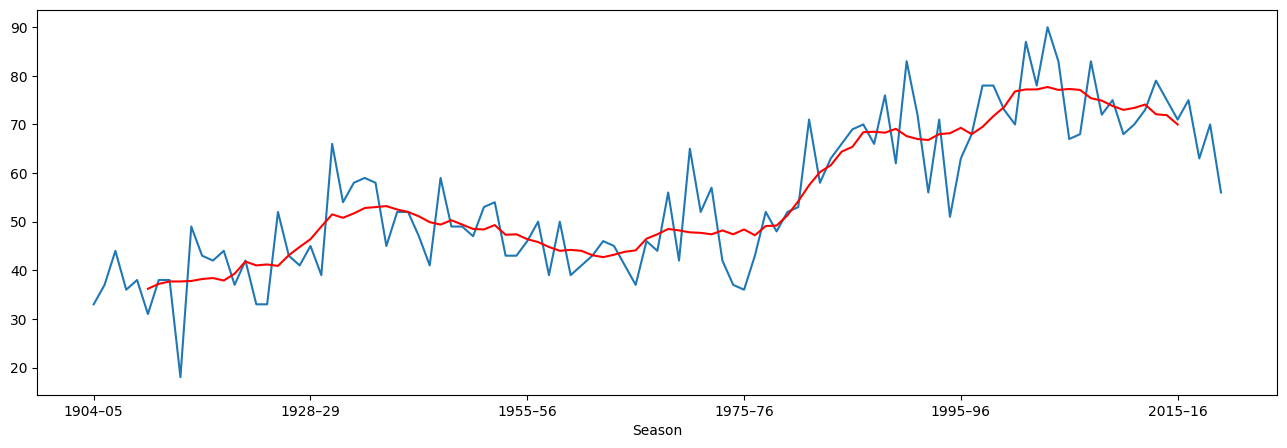

In [224]:
r = ts.rolling(window = 10, center=True)

figure(figsize=(16, 5))
ts['Points'].plot()
r.mean()['Points'].plot(color = 'red');

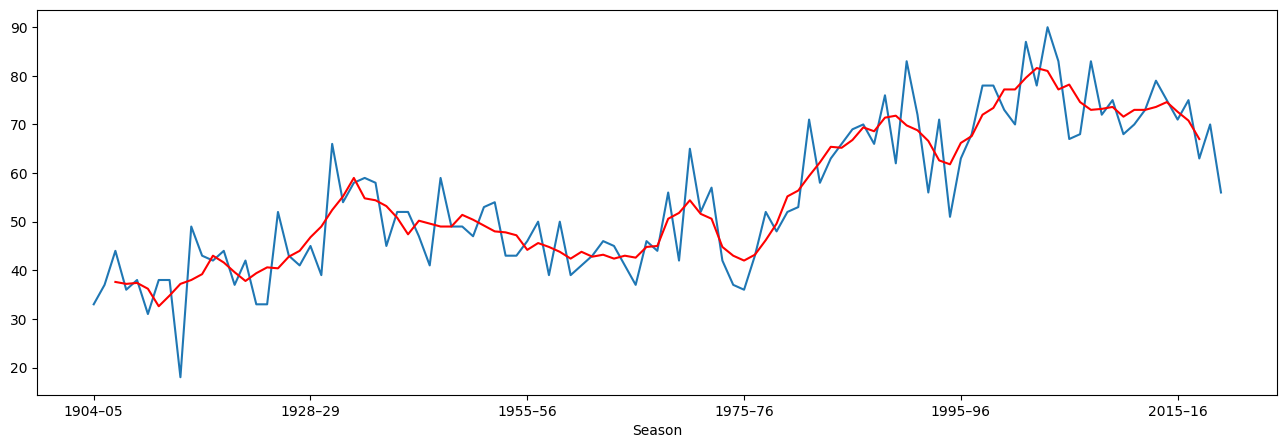

In [225]:
r = ts.rolling(window = 5, center=True)

figure(figsize=(16, 5))
ts['Points'].plot()
r.mean()['Points'].plot(color = 'red');

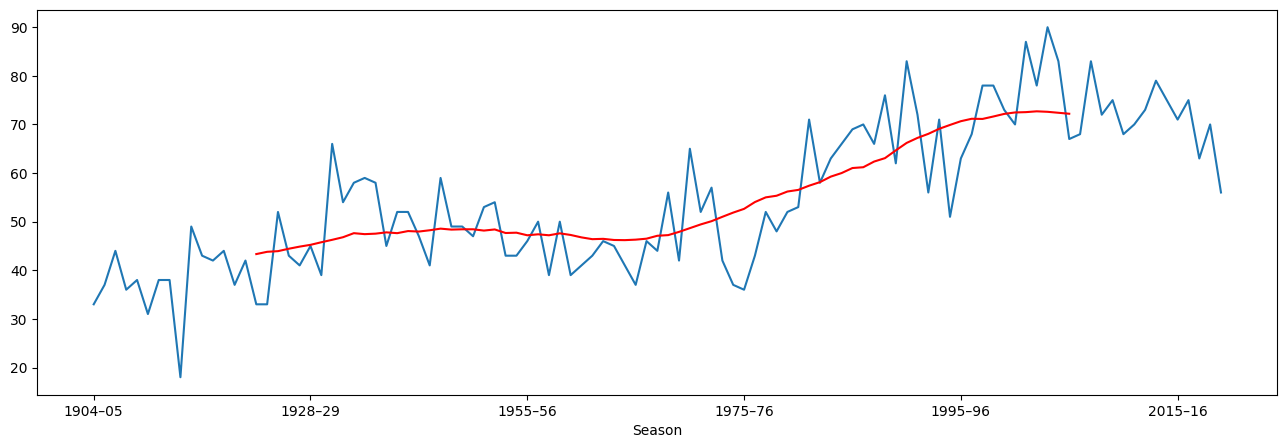

In [226]:
r = ts.rolling(window = 30, center=True)

figure(figsize=(16, 5))
ts['Points'].plot()
r.mean()['Points'].plot(color = 'red');

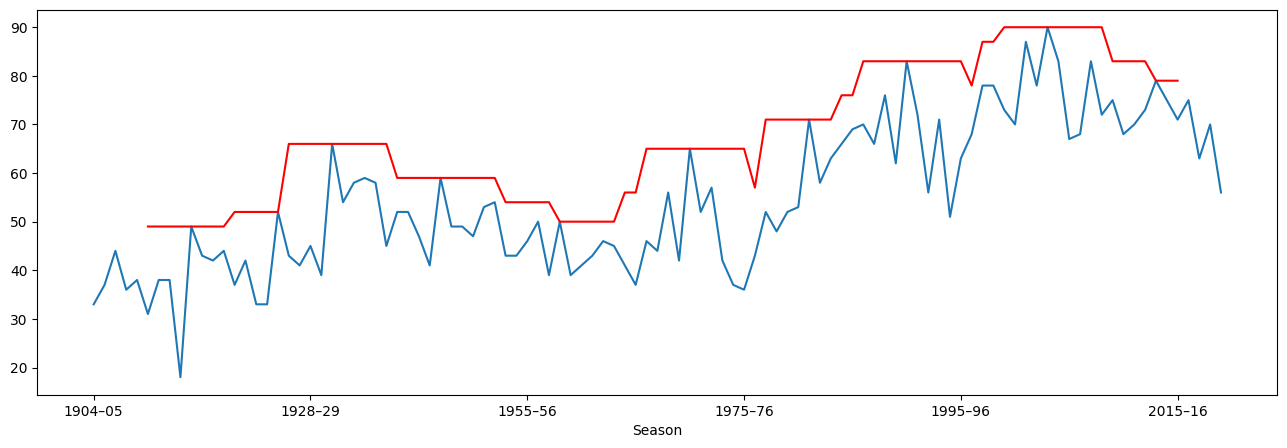

In [227]:
r = ts.rolling(window = 10, center=True)

figure(figsize=(16, 5))
ts['Points'].plot()
r.max()['Points'].plot(color = 'red');

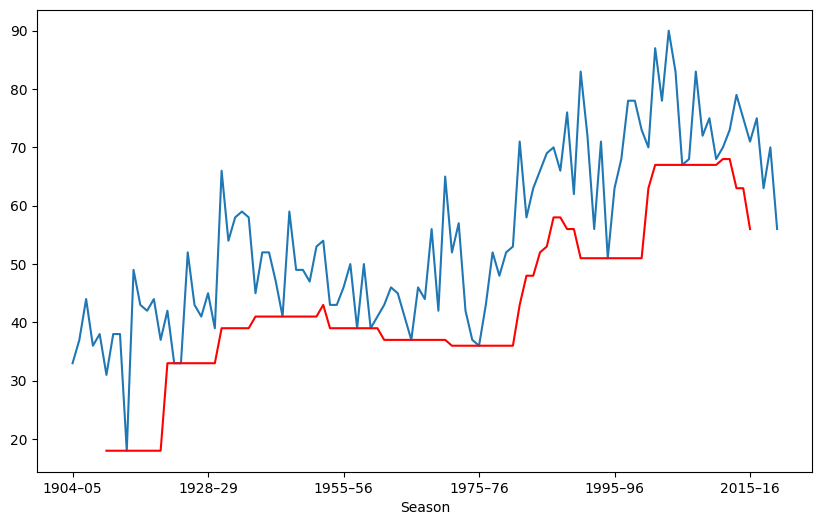

In [228]:
r = ts.rolling(window = 10, center=True)

figure(figsize=(10, 6))
ts['Points'].plot()
r.min()['Points'].plot(color = 'red');

### Features & Labels

Cuando entrenamos una serie temporal debemos saber bien cual es el label que queremos predecir. Es un caso concreto, ya que al ser dependiente de la variable tiempo si queremos predecir el valor en un instante t, entonces debemos trabajar con los valores inmediatamente previos.

Es decir, debemos elegir una serie de valores cuya label es el valor justo posterior, ya que hay una dependencia continua.

In [229]:
ts[0:10]

,Points
Season,
1904–05,33
1905–06,37
1906–07,44
1907–08,36
1908–09,38
1909–10,31
1910–11,38
1911–12,38
1912–13,18


In [230]:
tf_ts = tf.data.Dataset.from_tensor_slices(ts['Points'].values)

tf_ts = tf_ts.window(5, shift=1, drop_remainder=True)
tf_ts = tf_ts.flat_map(lambda window: window.batch(5))
tf_ts = tf_ts.map(lambda window: (window[:-1], window[-1:]))

for x,y in tf_ts:
    print(x.numpy(), y.numpy())

[33 37 44 36] [38]
[37 44 36 38] [31]
[44 36 38 31] [38]
[36 38 31 38] [38]
[38 31 38 38] [18]
[31 38 38 18] [49]
[38 38 18 49] [43]
[38 18 49 43] [42]
[18 49 43 42] [44]
[49 43 42 44] [37]
[43 42 44 37] [42]
[42 44 37 42] [33]
[44 37 42 33] [33]
[37 42 33 33] [52]
[42 33 33 52] [43]
[33 33 52 43] [41]
[33 52 43 41] [45]
[52 43 41 45] [39]
[43 41 45 39] [66]
[41 45 39 66] [54]
[45 39 66 54] [58]
[39 66 54 58] [59]
[66 54 58 59] [58]
[54 58 59 58] [45]
[58 59 58 45] [52]
[59 58 45 52] [52]
[58 45 52 52] [47]
[45 52 52 47] [41]
[52 52 47 41] [59]
[52 47 41 59] [49]
[47 41 59 49] [49]
[41 59 49 49] [47]
[59 49 49 47] [53]
[49 49 47 53] [54]
[49 47 53 54] [43]
[47 53 54 43] [43]
[53 54 43 43] [46]
[54 43 43 46] [50]
[43 43 46 50] [39]
[43 46 50 39] [50]
[46 50 39 50] [39]
[50 39 50 39] [41]
[39 50 39 41] [43]
[50 39 41 43] [46]
[39 41 43 46] [45]
[41 43 46 45] [41]
[43 46 45 41] [37]
[46 45 41 37] [46]
[45 41 37 46] [44]
[41 37 46 44] [56]
[37 46 44 56] [42]
[46 44 56 42] [65]
[44 56 42 65

In [231]:
tf_ts = tf.data.Dataset.from_tensor_slices(ts['Points'].values)

tf_ts = tf_ts.window(5, shift=1, drop_remainder=True)
tf_ts = tf_ts.flat_map(lambda window: window.batch(5))
tf_ts = tf_ts.map(lambda window: (window[:-1], window[-1:]))
tf_ts = tf_ts.shuffle(buffer_size=10)

for x,y in tf_ts:
    print(x.numpy(), y.numpy())

[18 49 43 42] [44]
[38 18 49 43] [42]
[49 43 42 44] [37]
[36 38 31 38] [38]
[43 42 44 37] [42]
[31 38 38 18] [49]
[37 44 36 38] [31]
[42 44 37 42] [33]
[33 37 44 36] [38]
[33 33 52 43] [41]
[42 33 33 52] [43]
[33 52 43 41] [45]
[39 66 54 58] [59]
[44 37 42 33] [33]
[52 43 41 45] [39]
[45 39 66 54] [58]
[54 58 59 58] [45]
[44 36 38 31] [38]
[41 45 39 66] [54]
[58 59 58 45] [52]
[43 41 45 39] [66]
[38 38 18 49] [43]
[66 54 58 59] [58]
[47 41 59 49] [49]
[49 49 47 53] [54]
[59 49 49 47] [53]
[41 59 49 49] [47]
[58 45 52 52] [47]
[45 52 52 47] [41]
[53 54 43 43] [46]
[43 46 50 39] [50]
[37 42 33 33] [52]
[46 50 39 50] [39]
[50 39 50 39] [41]
[50 39 41 43] [46]
[54 43 43 46] [50]
[39 41 43 46] [45]
[52 52 47 41] [59]
[59 58 45 52] [52]
[39 50 39 41] [43]
[41 37 46 44] [56]
[43 43 46 50] [39]
[38 31 38 38] [18]
[49 47 53 54] [43]
[43 46 45 41] [37]
[52 47 41 59] [49]
[65 52 57 42] [37]
[41 43 46 45] [41]
[57 42 37 36] [43]
[46 45 41 37] [46]
[37 36 43 52] [48]
[47 53 54 43] [43]
[43 52 48 52

In [232]:
def prep_ts(dt, window_size, shuffle=True):
    tf_ts = tf.data.Dataset.from_tensor_slices(dt['Points'].values)

    tf_ts = tf_ts.window(5, shift=1, drop_remainder=True)
    tf_ts = tf_ts.flat_map(lambda window: window.batch(window_size))
    tf_ts = tf_ts.map(lambda window: (window[:-1], window[-1:]))
    if shuffle:
        tf_ts = tf_ts.shuffle(buffer_size=10)

    features, labels = [], []
    for x,y in tf_ts:

        features.append(x)
        labels.append(y)

    return np.array(features), np.array(labels)

Para que los algoritmos funcionen mejor, escalar es una buena primera opción a probar.

Como en este caso la variable a predecir es la misma que la variable a entrenar, ya que es una serie temporal, entonces tendremos que obtener el valor inicial más adelante para mostrar los resultados reales.

In [233]:
scaler = StandardScaler()
ts[['Points']] = scaler.fit_transform(ts[['Points']])

In [234]:
train_size = int(len(ts) * 0.8)
train_set, test_set = ts[0:train_size], ts[train_size:]

In [235]:
WINDOW_SIZE = 5
X_train, y_train = prep_ts(train_set, WINDOW_SIZE)
X_test, y_test = prep_ts(test_set, WINDOW_SIZE)

In [236]:
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

## Forecasting

### ANN Sequential - 1 Capa

In [237]:
ann_seq_1 = keras.models.Sequential([
    keras.layers.Dense(50, activation="relu", input_shape = (1,WINDOW_SIZE-1)),
    keras.layers.Dense(1)
])

In [238]:
ann_seq_1.compile(loss="mean_squared_error", optimizer="adam")

In [239]:
ann_seq_1.fit(X_train, y_train, epochs=20)

Epoch 1/20


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.1188  
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.1790 
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.0074 
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.9564 
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.7689
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.8146
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.6964
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.5866
Epoch 9/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.6404
Epoch 10/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.6007
Epoch 11/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.5444
Epoch 12/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.4848
Epoch 13/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.4807
Epoch 14/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.4619
Epoch 15/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.4351 
Epoch 16/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms

In [240]:
# Una vez está entrenado el modelo, vamos a preparar los inputs pero esta vez sin cambiar el orden,
# y obtenemos las predicciones de todo el set. Antes hacíamos shuffle para evitar el bias, ahora que ya
# está entrenado, podemos tener todo ordenado para que cuando lo visualicemos veamos la serie original.

X_train_seq1, y_train_seq1 = prep_ts(train_set, WINDOW_SIZE, shuffle=False)
X_test_seq1, y_test_seq1 = prep_ts(test_set, WINDOW_SIZE, shuffle=False)

X_train_seq1 = np.reshape(X_train_seq1, (X_train_seq1.shape[0], 1, X_train_seq1.shape[1]))
X_test_seq1 = np.reshape(X_test_seq1, (X_test_seq1.shape[0], 1, X_test_seq1.shape[1]))

In [241]:
# Obtenemos las predicciones del set.

pred_train = ann_seq_1.predict(X_train_seq1)
pred_test = ann_seq_1.predict(X_test_seq1)

1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


In [242]:
print(pred_train.shape)
print(pred_test.shape)

(80, 1, 1)
(17, 1, 1)


In [243]:
# Volvemos a los valores iniciales, sin escalar, una vez hemos entrenado el modelo.

#pred_train = scaler.inverse_transform(pred_train)

# Redimensionamos a 2D
pred_train_2d = pred_train.reshape(-1, pred_train.shape[-1])
# Aplicamos inverse_transform
pred_train_rescaled = scaler.inverse_transform(pred_train_2d)
pred_train = pred_train_rescaled




#y_train_seq1 = scaler.inverse_transform([y_train_seq1])

# Si está en forma (samples, timesteps, 1) → aplánalo a 2D
y_train_seq1_2d = y_train_seq1.reshape(-1, y_train_seq1.shape[-1])
# Aplica inverse_transform
y_train_seq1_rescaled = scaler.inverse_transform(y_train_seq1_2d)
y_train_seq1 = y_train_seq1_rescaled






#pred_test = scaler.inverse_transform(pred_test)

pred_test_2d = pred_test.reshape(-1, pred_test.shape[-1])
# Aplicamos inverse_transform
pred_test_rescaled = scaler.inverse_transform(pred_test_2d)
pred_test = pred_test_rescaled






#y_test_seq1 = scaler.inverse_transform([y_test_seq1])

# Si está en forma (samples, timesteps, 1) → aplánalo a 2D
y_test_seq1_2d = y_test_seq1.reshape(-1, y_test_seq1.shape[-1])
# Aplica inverse_transform
y_test_seq1_rescaled = scaler.inverse_transform(y_test_seq1_2d)
y_test_seq1 = y_test_seq1_rescaled

In [244]:

print(y_train_seq1.shape)
print(pred_train.shape)
print(y_test_seq1.shape)
print(pred_test.shape)

(80, 1)
(80, 1)
(17, 1)
(17, 1)


In [245]:
ann_seq_1_rmse = np.sqrt(mean_squared_error(y_test_seq1, pred_test))

print(ann_seq_1_rmse)


14.564456679022634


In [246]:
# Concatenar directamente los arreglos 2D
y_show_train = y_train_seq1
y_show_test = y_test_seq1
# Concatenar ambos conjuntos de datos (manteniendo la forma 2D)
y_show = np.concatenate((y_show_train, y_show_test), axis=0)


In [247]:
# Concatenar directamente los arreglos 2D
y_show_pred_train = pred_train
y_show_pred_test = pred_test
# Concatenar ambos conjuntos de datos (manteniendo la forma 2D)
y_show_pred = np.concatenate((y_show_pred_train, y_show_pred_test), axis=0)

RMSE Mean: 14.564


,RMSE
ANN Sequential Model - 1 Capa,14.564


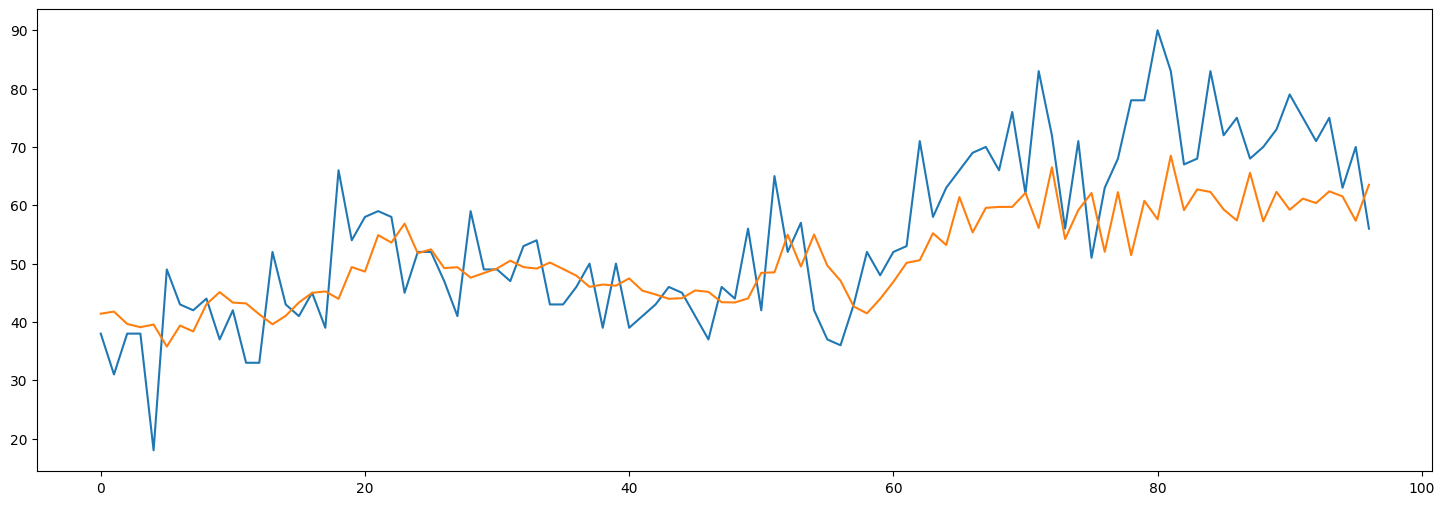

In [248]:
# Métricas
print("RMSE Mean:", np.round(ann_seq_1_rmse, 3))

# Visualizamos
figure(num=None, figsize=(18, 6))
plt.plot(y_show)
plt.plot(y_show_pred)

# Añadir a la tabla comparativa
model_comparative = AddModel('ANN Sequential Model - 1 Capa', ann_seq_1_rmse, model_comparative)
model_comparative.sort_values(by=['RMSE'], ascending=True).head()

### ANN Sequential - 2 Capas

In [249]:
ann_seq_2 = keras.models.Sequential([
    keras.layers.Dense(200, activation="relu", input_shape = (1,WINDOW_SIZE-1)),
    keras.layers.Dense(50, activation="relu"),
    keras.layers.Dense(1)
])

In [250]:
ann_seq_2.compile(loss="mean_squared_error", optimizer="adam")

In [251]:
ann_seq_2.fit(X_train, y_train, epochs=20)

Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.6343 
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.5321 
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.3969
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.3048
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.3282
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.3294 
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.3425
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2763 
Epoch 9/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.2874
Epoch 10/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.3083
Epoch 11/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.3139
Epoch 12/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.2769
Epoch 13/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.2715
Epoch 14/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.2737
Epoch 15/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.3009
Epoch 16/20
3/3 ━━━━━━━━━━━━━━━━━

In [252]:
# Una vez está entrenado el modelo, vamos a preparar los inputs pero esta vez sin cambiar el orden,
# y obtenemos las predicciones de todo el set. Antes hacíamos shuffle para evitar el bias, ahora que ya
# está entrenado, podemos tener todo ordenado para que cuando lo visualicemos veamos la serie original.

X_train_seq2, y_train_seq2 = prep_ts(train_set, WINDOW_SIZE, shuffle=False)
X_test_seq2, y_test_seq2 = prep_ts(test_set, WINDOW_SIZE, shuffle=False)

X_train_seq2 = np.reshape(X_train_seq2, (X_train_seq2.shape[0], 1, X_train_seq2.shape[1]))
X_test_seq2 = np.reshape(X_test_seq2, (X_test_seq2.shape[0], 1, X_test_seq2.shape[1]))

In [253]:
# Obtenemos las predicciones del set.

pred_train = ann_seq_2.predict(X_train_seq2)
pred_test = ann_seq_2.predict(X_test_seq2)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


In [254]:
# Volvemos a los valores iniciales, sin escalar, una vez hemos entrenado el modelo.

#pred_train = scaler.inverse_transform(pred_train)

# Redimensionamos a 2D
pred_train_2d = pred_train.reshape(-1, pred_train.shape[-1])
# Aplicamos inverse_transform
pred_train_rescaled = scaler.inverse_transform(pred_train_2d)
pred_train = pred_train_rescaled




#y_train_seq1 = scaler.inverse_transform([y_train_seq1])

# Si está en forma (samples, timesteps, 1) → aplánalo a 2D
y_train_seq2_2d = y_train_seq2.reshape(-1, y_train_seq2.shape[-1])
# Aplica inverse_transform
y_train_seq2_rescaled = scaler.inverse_transform(y_train_seq2_2d)
y_train_seq2 = y_train_seq2_rescaled






#pred_test = scaler.inverse_transform(pred_test)

pred_test_2d = pred_test.reshape(-1, pred_test.shape[-1])
# Aplicamos inverse_transform
pred_test_rescaled = scaler.inverse_transform(pred_test_2d)
pred_test = pred_test_rescaled






#y_test_seq1 = scaler.inverse_transform([y_test_seq1])

# Si está en forma (samples, timesteps, 1) → aplánalo a 2D
y_test_seq2_2d = y_test_seq2.reshape(-1, y_test_seq2.shape[-1])
# Aplica inverse_transform
y_test_seq2_rescaled = scaler.inverse_transform(y_test_seq2_2d)
y_test_seq2 = y_test_seq2_rescaled

In [255]:
# Obtenemos la métrica que buscamos
ann_seq_2_rmse = np.sqrt(mean_squared_error(y_test_seq2, pred_test))

In [256]:
# Concatenar directamente los arreglos 2D
y_show_train = y_train_seq2
y_show_test = y_test_seq2
# Concatenar ambos conjuntos de datos (manteniendo la forma 2D)
y_show = np.concatenate((y_show_train, y_show_test), axis=0)



In [257]:
# Concatenar directamente los arreglos 2D
y_show_pred_train = pred_train
y_show_pred_test = pred_test
# Concatenar ambos conjuntos de datos (manteniendo la forma 2D)
y_show_pred = np.concatenate((y_show_pred_train, y_show_pred_test), axis=0)

RMSE Mean: 8.623


,RMSE
ANN Sequential Model - 2 Capas,8.623
ANN Sequential Model - 1 Capa,14.564


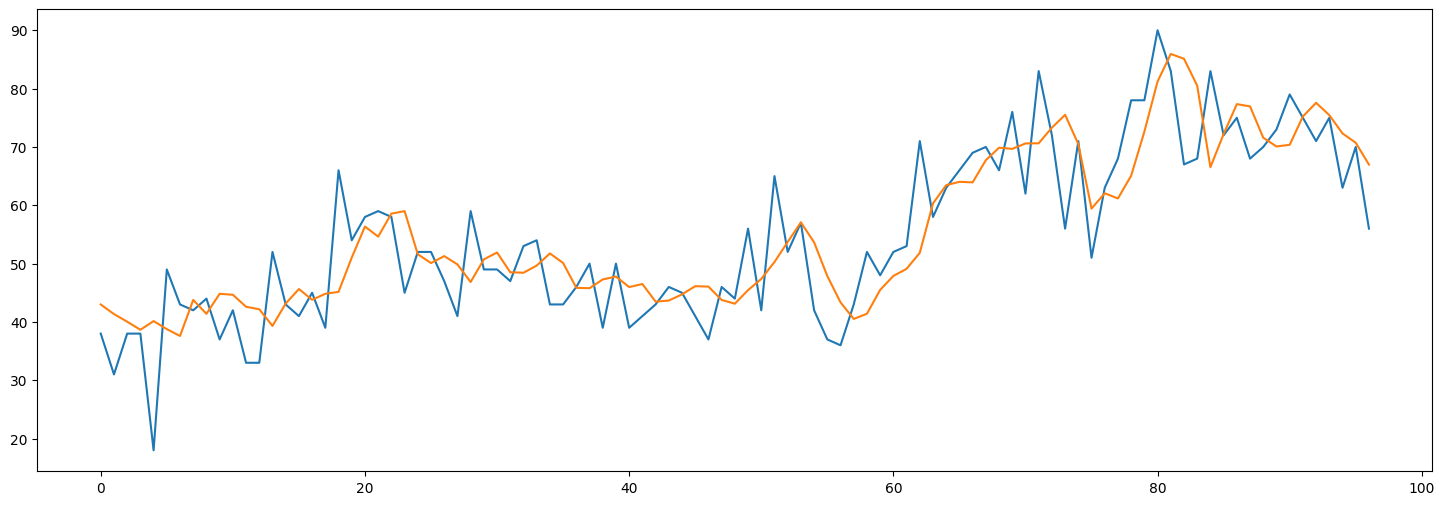

In [258]:
# Métricas
print("RMSE Mean:", np.round(ann_seq_2_rmse, 3))

# Visualizamos
figure(num=None, figsize=(18, 6))
plt.plot(y_show)
plt.plot(y_show_pred)

# Añadir a la tabla comparativa
model_comparative = AddModel('ANN Sequential Model - 2 Capas', ann_seq_2_rmse, model_comparative)
model_comparative.sort_values(by=['RMSE'], ascending=True).head()

### ANN Sequential - 3 Capas

In [259]:
ann_seq_3 = keras.models.Sequential([
    keras.layers.Dense(300, activation="relu", input_shape = (1,WINDOW_SIZE-1)),
    keras.layers.Dense(200, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(1)
])

In [260]:
ann_seq_3.compile(loss="mean_squared_error", optimizer="adam")

In [261]:
ann_seq_3.fit(X_train, y_train, epochs=20)

Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.6496
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.3942
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.3597
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.3445
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.3029 
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.3095
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.3114
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2605 
Epoch 9/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2601 
Epoch 10/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.2922
Epoch 11/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.3010
Epoch 12/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2417 
Epoch 13/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.2495
Epoch 14/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.2769
Epoch 15/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.2431
Epoch 16/20
3/3 ━━━━━━━━━━━━━━━━━━

In [262]:
# Una vez está entrenado el modelo, vamos a preparar los inputs pero esta vez sin cambiar el orden,
# y obtenemos las predicciones de todo el set. Antes hacíamos shuffle para evitar el bias, ahora que ya
# está entrenado, podemos tener todo ordenado para que cuando lo visualicemos veamos la serie original.

X_train_seq3, y_train_seq3 = prep_ts(train_set, WINDOW_SIZE, shuffle=False)
X_test_seq3, y_test_seq3 = prep_ts(test_set, WINDOW_SIZE, shuffle=False)

X_train_seq3 = np.reshape(X_train_seq3, (X_train_seq3.shape[0], 1, X_train_seq3.shape[1]))
X_test_seq3 = np.reshape(X_test_seq3, (X_test_seq3.shape[0], 1, X_test_seq3.shape[1]))

In [263]:
# Obtenemos las predicciones del set.
pred_train = ann_seq_3.predict(X_train_seq3)
pred_test = ann_seq_3.predict(X_test_seq3)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


In [264]:
# Volvemos a los valores iniciales, sin escalar, una vez hemos entrenado el modelo.

#pred_train = scaler.inverse_transform(pred_train)

# Redimensionamos a 2D
pred_train_2d = pred_train.reshape(-1, pred_train.shape[-1])
# Aplicamos inverse_transform
pred_train_rescaled = scaler.inverse_transform(pred_train_2d)
pred_train = pred_train_rescaled




#y_train_seq1 = scaler.inverse_transform([y_train_seq1])

# Si está en forma (samples, timesteps, 1) → aplánalo a 2D
y_train_seq3_2d = y_train_seq3.reshape(-1, y_train_seq3.shape[-1])
# Aplica inverse_transform
y_train_seq3_rescaled = scaler.inverse_transform(y_train_seq3_2d)
y_train_seq3 = y_train_seq3_rescaled






#pred_test = scaler.inverse_transform(pred_test)

pred_test_2d = pred_test.reshape(-1, pred_test.shape[-1])
# Aplicamos inverse_transform
pred_test_rescaled = scaler.inverse_transform(pred_test_2d)
pred_test = pred_test_rescaled






#y_test_seq1 = scaler.inverse_transform([y_test_seq1])

# Si está en forma (samples, timesteps, 1) → aplánalo a 2D
y_test_seq3_2d = y_test_seq3.reshape(-1, y_test_seq3.shape[-1])
# Aplica inverse_transform
y_test_seq3_rescaled = scaler.inverse_transform(y_test_seq3_2d)
y_test_seq3 = y_test_seq3_rescaled

In [265]:
# Obtenemos la métrica que buscamos
ann_seq_3_rmse = np.sqrt(mean_squared_error(y_test_seq3, pred_test))

In [266]:
# Preparamos los datos para poder visualizarlos correctamente

# Concatenar directamente los arreglos 2D
y_show_train = y_train_seq3
y_show_test = y_test_seq3
# Concatenar ambos conjuntos de datos (manteniendo la forma 2D)
y_show = np.concatenate((y_show_train, y_show_test), axis=0)


# Concatenar directamente los arreglos 2D
y_show_pred_train = pred_train
y_show_pred_test = pred_test
# Concatenar ambos conjuntos de datos (manteniendo la forma 2D)
y_show_pred = np.concatenate((y_show_pred_train, y_show_pred_test), axis=0)

RMSE Mean: 9.128


,RMSE
ANN Sequential Model - 2 Capas,8.623
ANN Sequential Model - 3 Capas,9.128
ANN Sequential Model - 1 Capa,14.564


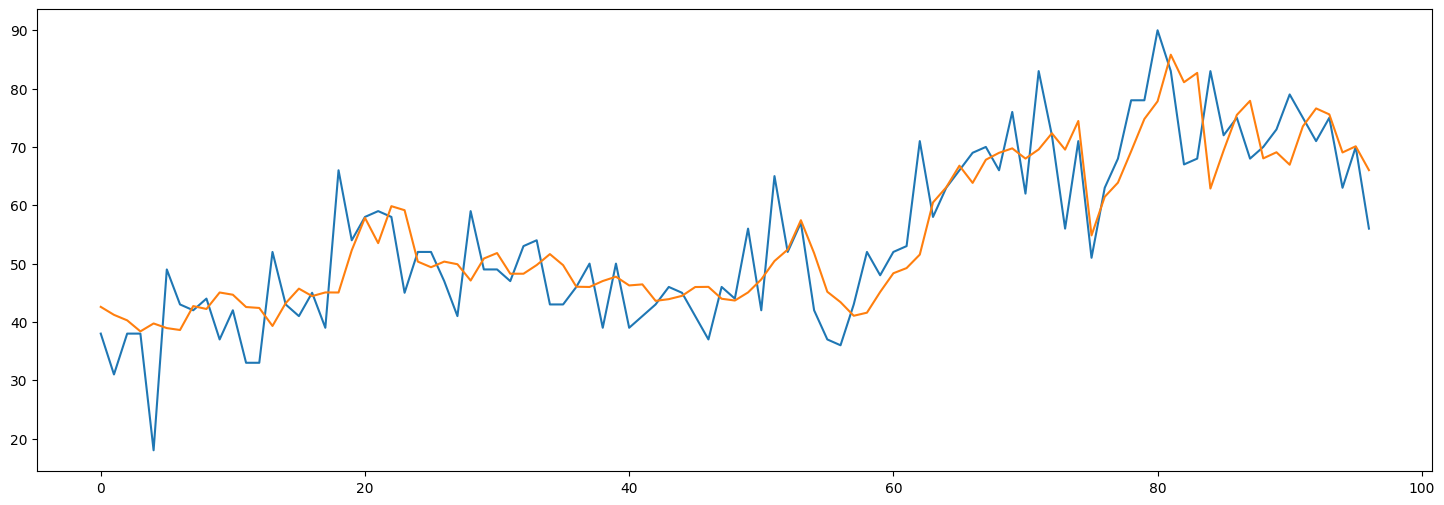

In [267]:
# Métricas
print("RMSE Mean:", np.round(ann_seq_3_rmse, 3))

# Visualizamos
figure(num=None, figsize=(18, 6))
plt.plot(y_show)
plt.plot(y_show_pred)

# Añadir a la tabla comparativa
model_comparative = AddModel('ANN Sequential Model - 3 Capas', ann_seq_3_rmse, model_comparative)
model_comparative.sort_values(by=['RMSE'], ascending=True).head()

### RNN: Recurrent Neural Networks

In [268]:
ann_rnn = tf.keras.models.Sequential([

    tf.keras.layers.SimpleRNN(100),

    tf.keras.layers.Dense(1),
])

In [269]:
ann_rnn.compile(loss="mean_squared_error", optimizer="adam")

In [270]:
ann_rnn.fit(X_train, y_train, epochs=20)

Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.5937
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.4204 
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.3781
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.3647
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.3618
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.3569
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.3352
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.3528 
Epoch 9/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.3112
Epoch 10/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.3284
Epoch 11/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.3196
Epoch 12/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.3451
Epoch 13/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.2994
Epoch 14/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.3249
Epoch 15/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.2711
Epoch 16/20
3/3 ━━━━━━━━━━━━━━━━━━

In [271]:
# Una vez está entrenado el modelo, vamos a preparar los inputs pero esta vez sin cambiar el orden,
# y obtenemos las predicciones de todo el set. Antes hacíamos shuffle para evitar el bias, ahora que ya
# está entrenado, podemos tener todo ordenado para que cuando lo visualicemos veamos la serie original.

X_train_rnn, y_train_rnn = prep_ts(train_set, WINDOW_SIZE, shuffle=False)
X_test_rnn, y_test_rnn = prep_ts(test_set, WINDOW_SIZE, shuffle=False)

X_train_rnn = np.reshape(X_train_rnn, (X_train_rnn.shape[0], 1, X_train_rnn.shape[1]))
X_test_rnn = np.reshape(X_test_rnn, (X_test_rnn.shape[0], 1, X_test_rnn.shape[1]))

In [272]:
print(X_train_rnn)

[[[-1.45389346 -1.18712402 -0.72027749 -1.25381638]]

 [[-1.18712402 -0.72027749 -1.25381638 -1.12043166]]

 [[-0.72027749 -1.25381638 -1.12043166 -1.58727818]]

 [[-1.25381638 -1.12043166 -1.58727818 -1.12043166]]

 [[-1.12043166 -1.58727818 -1.12043166 -1.12043166]]

 [[-1.58727818 -1.12043166 -1.12043166 -2.45427887]]

 [[-1.12043166 -1.12043166 -2.45427887 -0.38681569]]

 [[-1.12043166 -2.45427887 -0.38681569 -0.78696985]]

 [[-2.45427887 -0.38681569 -0.78696985 -0.85366221]]

 [[-0.38681569 -0.78696985 -0.85366221 -0.72027749]]

 [[-0.78696985 -0.85366221 -0.72027749 -1.18712402]]

 [[-0.85366221 -0.72027749 -1.18712402 -0.85366221]]

 [[-0.72027749 -1.18712402 -0.85366221 -1.45389346]]

 [[-1.18712402 -0.85366221 -1.45389346 -1.45389346]]

 [[-0.85366221 -1.45389346 -1.45389346 -0.18673861]]

 [[-1.45389346 -1.45389346 -0.18673861 -0.78696985]]

 [[-1.45389346 -0.18673861 -0.78696985 -0.92035458]]

 [[-0.18673861 -0.78696985 -0.92035458 -0.65358513]]

 [[-0.78696985 -0.92035458 -

In [273]:
# Obtenemos las predicciones del set.

pred_train = ann_rnn.predict(X_train_rnn)
pred_test = ann_rnn.predict(X_test_rnn)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


In [274]:
# Volvemos a los valores iniciales, sin escalar, una vez hemos entrenado el modelo.

#pred_train = scaler.inverse_transform(pred_train)

# Redimensionamos a 2D
pred_train_2d = pred_train.reshape(-1, pred_train.shape[-1])
# Aplicamos inverse_transform
pred_train_rescaled = scaler.inverse_transform(pred_train_2d)
pred_train = pred_train_rescaled




#y_train_seq1 = scaler.inverse_transform([y_train_seq1])

# Si está en forma (samples, timesteps, 1) → aplánalo a 2D
y_train_rnn_2d = y_train_rnn.reshape(-1, y_train_rnn.shape[-1])
# Aplica inverse_transform
y_train_rnn_rescaled = scaler.inverse_transform(y_train_rnn_2d)
y_train_rnn = y_train_rnn_rescaled






#pred_test = scaler.inverse_transform(pred_test)

pred_test_2d = pred_test.reshape(-1, pred_test.shape[-1])
# Aplicamos inverse_transform
pred_test_rescaled = scaler.inverse_transform(pred_test_2d)
pred_test = pred_test_rescaled






#y_test_seq1 = scaler.inverse_transform([y_test_seq1])

# Si está en forma (samples, timesteps, 1) → aplánalo a 2D
y_test_rnn_2d = y_test_rnn.reshape(-1, y_test_rnn.shape[-1])
# Aplica inverse_transform
y_test_rnn_rescaled = scaler.inverse_transform(y_test_rnn_2d)
y_test_rnn = y_test_rnn_rescaled

In [275]:
# Obtenemos la métrica que buscamos
rnn_rmse = np.sqrt(mean_squared_error(y_test_rnn, pred_test))

In [276]:
# Preparamos los datos para poder visualizarlos correctamente

# Concatenar directamente los arreglos 2D
y_show_train = y_train_rnn
y_show_test = y_test_rnn
# Concatenar ambos conjuntos de datos (manteniendo la forma 2D)
y_show = np.concatenate((y_show_train, y_show_test), axis=0)


# Concatenar directamente los arreglos 2D
y_show_pred_train = pred_train
y_show_pred_test = pred_test
# Concatenar ambos conjuntos de datos (manteniendo la forma 2D)
y_show_pred = np.concatenate((y_show_pred_train, y_show_pred_test), axis=0)

RMSE Mean: 7.436


,RMSE
RNN Model,7.436
ANN Sequential Model - 2 Capas,8.623
ANN Sequential Model - 3 Capas,9.128
ANN Sequential Model - 1 Capa,14.564


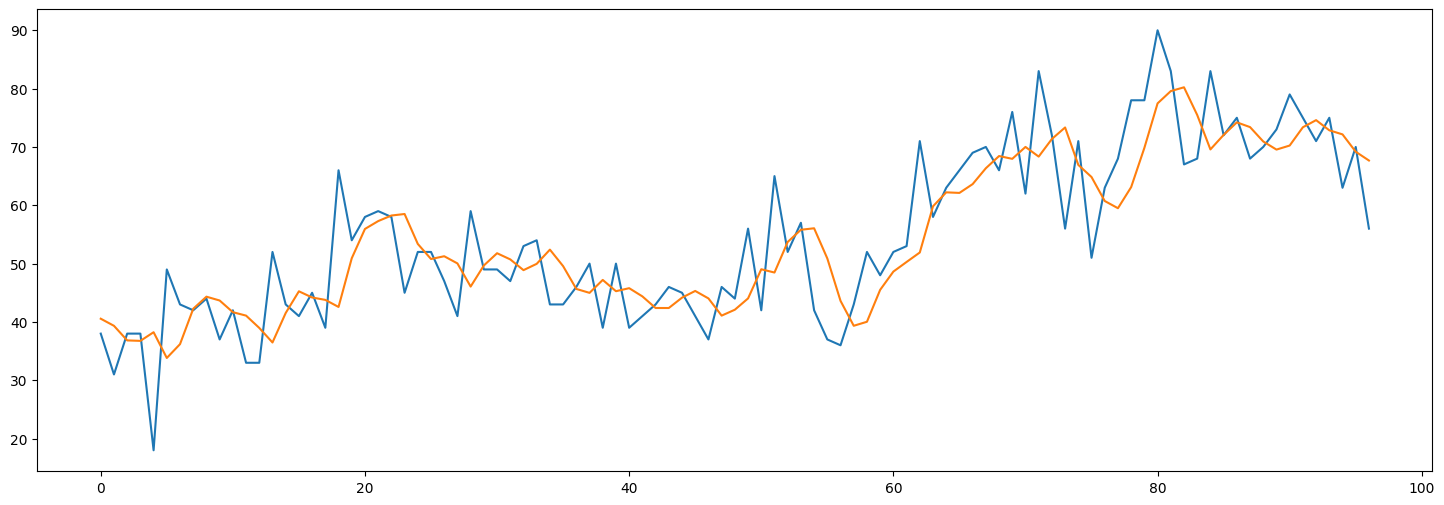

In [277]:
# Métricas
print("RMSE Mean:", np.round(rnn_rmse, 3))

# Visualizamos
figure(num=None, figsize=(18, 6))
plt.plot(y_show)
plt.plot(y_show_pred)

# Añadir a la tabla comparativa
model_comparative = AddModel('RNN Model', rnn_rmse, model_comparative)
model_comparative.sort_values(by=['RMSE'], ascending=True).head()

### LSTM: Long Short Term Memory

In [278]:
ann_lstm = tf.keras.models.Sequential([

    tf.keras.layers.LSTM(300),

    tf.keras.layers.Dense(1),
])

In [279]:
ann_lstm.compile(loss="mean_squared_error", optimizer="adam")

In [280]:
ann_lstm.fit(X_train, y_train, epochs=20)

Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.7212
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.6440 
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.5336
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.5307
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.4164
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.3955
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.4171 
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.3598 
Epoch 9/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.3866 
Epoch 10/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.3152
Epoch 11/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.3574 
Epoch 12/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.3155
Epoch 13/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.3302 
Epoch 14/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.3777
Epoch 15/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.3237
Epoch 16/20
3/3 ━━━━━━━━━━━━━━━━━━━

In [281]:
# Una vez está entrenado el modelo, vamos a preparar los inputs pero esta vez sin cambiar el orden,
# y obtenemos las predicciones de todo el set. Antes hacíamos shuffle para evitar el bias, ahora que ya
# está entrenado, podemos tener todo ordenado para que cuando lo visualicemos veamos la serie original.

X_train_lstm, y_train_lstm = prep_ts(train_set, WINDOW_SIZE, shuffle=False)
X_test_lstm, y_test_lstm = prep_ts(test_set, WINDOW_SIZE, shuffle=False)

X_train_lstm = np.reshape(X_train_lstm, (X_train_lstm.shape[0], 1, X_train_lstm.shape[1]))
X_test_lstm = np.reshape(X_test_lstm, (X_test_lstm.shape[0], 1, X_test_lstm.shape[1]))

In [282]:
# Obtenemos las predicciones del set.

pred_train = ann_lstm.predict(X_train_lstm)
pred_test = ann_lstm.predict(X_test_lstm)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


In [283]:

# Volvemos a los valores iniciales, sin escalar, una vez hemos entrenado el modelo.

#pred_train = scaler.inverse_transform(pred_train)

# Redimensionamos a 2D
pred_train_2d = pred_train.reshape(-1, pred_train.shape[-1])
# Aplicamos inverse_transform
pred_train_rescaled = scaler.inverse_transform(pred_train_2d)
pred_train = pred_train_rescaled




#y_train_seq1 = scaler.inverse_transform([y_train_seq1])

# Si está en forma (samples, timesteps, 1) → aplánalo a 2D
y_train_lstm_2d = y_train_lstm.reshape(-1, y_train_lstm.shape[-1])
# Aplica inverse_transform
y_train_lstm_rescaled = scaler.inverse_transform(y_train_lstm_2d)
y_train_lstm = y_train_lstm_rescaled






#pred_test = scaler.inverse_transform(pred_test)

pred_test_2d = pred_test.reshape(-1, pred_test.shape[-1])
# Aplicamos inverse_transform
pred_test_rescaled = scaler.inverse_transform(pred_test_2d)
pred_test = pred_test_rescaled






#y_test_seq1 = scaler.inverse_transform([y_test_seq1])

# Si está en forma (samples, timesteps, 1) → aplánalo a 2D
y_test_lstm_2d = y_test_lstm.reshape(-1, y_test_lstm.shape[-1])
# Aplica inverse_transform
y_test_lstm_rescaled = scaler.inverse_transform(y_test_lstm_2d)
y_test_lstm = y_test_lstm_rescaled

In [284]:
# Obtenemos la métrica que buscamos
lstm_rmse = np.sqrt(mean_squared_error(y_test_lstm, pred_test))

In [285]:
# Preparamos los datos para poder visualizarlos correctamente

# Concatenar directamente los arreglos 2D
y_show_train = y_train_lstm
y_show_test = y_test_lstm
# Concatenar ambos conjuntos de datos (manteniendo la forma 2D)
y_show = np.concatenate((y_show_train, y_show_test), axis=0)


# Concatenar directamente los arreglos 2D
y_show_pred_train = pred_train
y_show_pred_test = pred_test
# Concatenar ambos conjuntos de datos (manteniendo la forma 2D)
y_show_pred = np.concatenate((y_show_pred_train, y_show_pred_test), axis=0)

RMSE Mean: 7.619


,RMSE
RNN Model,7.436
LSTM Model,7.619
ANN Sequential Model - 2 Capas,8.623
ANN Sequential Model - 3 Capas,9.128
ANN Sequential Model - 1 Capa,14.564


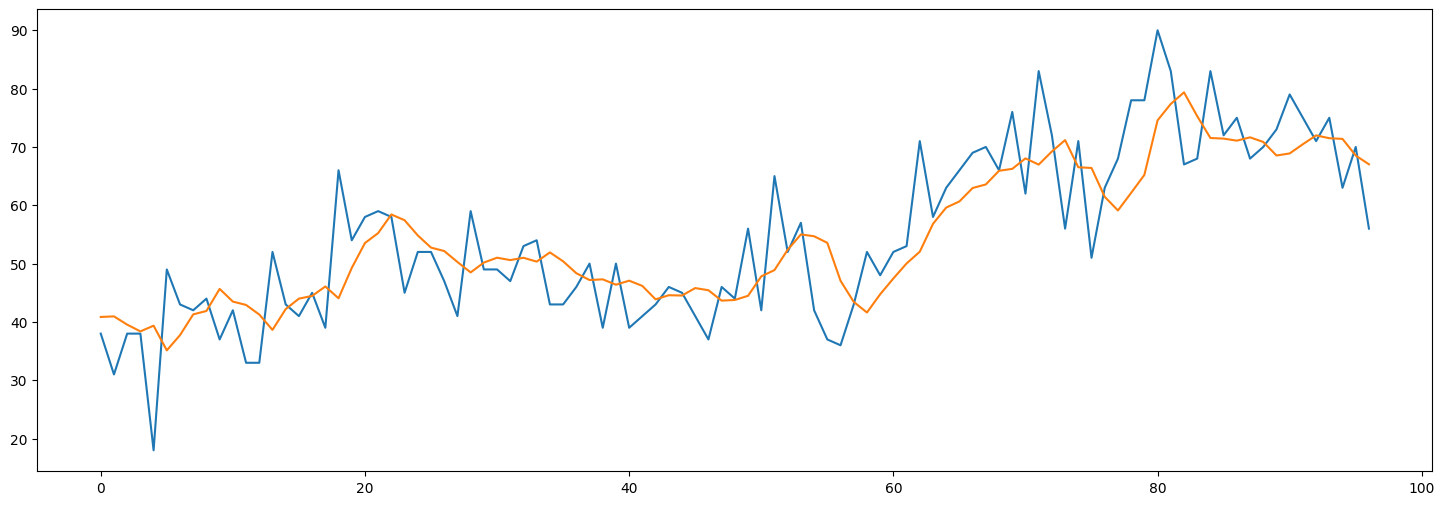

In [286]:
# Métricas
print("RMSE Mean:", np.round(lstm_rmse, 3))

# Visualizamos
figure(num=None, figsize=(18, 6))
plt.plot(y_show)
plt.plot(y_show_pred)

# Añadir a la tabla comparativa
model_comparative = AddModel('LSTM Model', lstm_rmse, model_comparative)
model_comparative.sort_values(by=['RMSE'], ascending=True).head()

### Si quieres probar con otros datasets, ejecuta los otros proporcionados.

 - Manchester City dataset.
 - Manchester United dataset.
 - Chelsea dataset.

Verás como los resultados son diferentes, por ejemplo el Manchester City tiene una subida demasiado grande en los últimos años lo que provoca un cambio de ciclo que dificulta la predicción.

Juega con WINDOW_SIZE, el número de capas, el número de neuronas... ¡y a ver qué sale!

In [291]:
# Definir WINDOW_SIZE (asegúrate de que este valor es correcto)
WINDOW_SIZE = 5


# Obtener los años del índice
años = ts.index.values

# 1. Obtener la última secuencia de datos escalados
last_sequence_scaled = ts[['Points']][-WINDOW_SIZE:]

last_sequence_scaled = prep_ts(last_sequence_scaled, WINDOW_SIZE, shuffle=False)

abc = np.reshape(last_sequence_scaled, (last_sequence_scaled.shape[0], 1, last_sequence_scaled.shape[1]))

print(abc)

# 3. Realizar la predicción
pred_scaled_next_year = ann_rnn.predict(abc)

# 4. Invertir el escalado
pred_next_year = scaler.inverse_transform(pred_scaled_next_year)[0, 0]

# 5. Mostrar la Predicción
ultimo_año_str = años[-1]
if '–' in ultimo_año_str:
    ultimo_año = int(ultimo_año_str.split('–')[0])
else:
    ultimo_año = int(ultimo_año_str)

año_siguiente = ultimo_año + 1
prediccion_siguiente_temporada = f"{año_siguiente}-{año_siguiente + 1}"
print(f"Predicción de puntos para la temporada {prediccion_siguiente_temporada}: {np.round(pred_next_year, 3)}")


AttributeError: 'tuple' object has no attribute 'shape'